#### Summary:

This notebook is the testing ground for a script to analyze snRNA data. Specifically, this will be designed for nPOD samples.

This is a cleaned up copy of the third version of the sample specific cell QC filtering methods we are establishing. Here we filter the raw matrix by thresholds (RNA genes >= 500, ATAC fragments >= 1000), remove multiplets (called by CellRanger), and then perform SoupX to adjust the RNA counts based on background contamination. 

In [116]:
#always run this first!!
#essential reticulate functions that allow us to use python packages in R
#you'll need a conda env with 'leidenalg' and 'pandas' installed to do this
#then route reticulate to the python installed in that conda env with the below functions
Sys.setenv(RETICULATE_PYTHON="/home/.conda/envs/decontX_reticulate/bin/python")
library(reticulate)
reticulate::use_python("/home/.conda/envs/decontX_reticulate/bin/python")
reticulate::use_condaenv("/home/.conda/envs/decontX_reticulate")
reticulate::py_module_available(module='leidenalg') #needs to be TRUE
reticulate::import('leidenalg') #good to make sure this doesn't error

[1] TRUE

Module(leidenalg)

In [117]:
library(Seurat)
library(Signac)
library(EnsDb.Hsapiens.v86)
library(dplyr)
library(ggplot2)
library(Matrix)
library(harmony)
library(stringr)
library(gridExtra)

source('231121_WE_Graphing_Clustering_Functions.R')

#suppressMessages(library(hdf5r))
#suppressMessages(library(data.table))
#suppressMessages(library(ggpubr))
#
#
#warnLevel <- getOption('warn')
#options(warn = -1)
#
#library(DoubletFinder)
#library(scater)
##library(celda)

In [3]:
sessionInfo()

R version 4.3.1 (2023-06-16)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 20.04.2 LTS

Matrix products: default
BLAS/LAPACK: /home/welison/.conda/envs/mamba/envs/seurat5.0_decontx/lib/libopenblasp-r0.3.21.so;  LAPACK version 3.9.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

time zone: America/Los_Angeles
tzcode source: system (glibc)

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] gridExtra_2.3             stringr_1.5.1            
 [3] harmony_1.2.0             Rcpp_1.0.11              
 [5] Matrix_1.6-4              ggplot2_3.4.4            
 [7] dplyr_1.1.

# Read in data

This is the latest pooled data for nPOD  

Cellranger and initial clean up (500 Features RNA, 1000 atac fragments)

In [92]:
# Set some values and load sample list
dataset <- 'nPOD'
modality <- 'Pooled'

samp_dir <- paste0("/nfs/lab/projects/mega_pancreas/data/cellranger/",dataset,"/", modality, "/")


samples <- list.dirs(samp_dir, full.names = FALSE, recursive = FALSE)
samples = samples[samples != "intermediates"]

samples

[1] "MM_1349_1_2_MM_1345_1_2" "MM_1350_1_2_MM_1346_1_2"
[3] "MM_1351_1_2_MM_1347_1_2" "MM_1352_1_2_MM_1348_1_2"
[5] "QY_2312_1_2_QY_2311_1_2" "QY_2314_1_2_QY_2313_1_2"
[7] "QY_2316_1_2_QY_2315_1_2" "QY_2318_1_2_QY_2317_1_2"

In [67]:
# Load sample metadata to attach
sample_info <- read.table('/nfs/lab/projects/npod_aab/data/012824_metadata.tsv', 
           sep='\t', header=T)

dim(sample_info)

#sample_info <- read.table('/nfs/lab/projects/npod_aab/data/012824_metadata.tsv', 
#           sep='\t', header=T)

sample_info
#dataset_sample_info <- filter(sample_info, Dataset==dataset)

[1] 34 12

donor_demux,Donor.Type,AAb.status,Age..yrs.,NoAbs,Gender,Race,BMI,HbA1C,GRS1..European.Hispanic,GRS.High.Low...0.28,Bullshit.Percentiles
<chr>,<chr>,<chr>,<dbl>,<int>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<dbl>
6301,Autoab Pos,GADA+,26.00,1,Male,African Am,32.08,5.5,0.187200,low,0.0200
6303,Autoab Pos,GADA+,22.00,1,Male,Caucasian,31.90,5.4,0.282700,high,0.6000
6314,Autoab Pos,GADA+,21.00,1,Male,Caucasian,23.80,,0.244000,low,0.1300
6347,Autoab Pos,mIAA+*,8.50,1,Male,Caucasian,19.50,,0.160670,low,0.0100
6397,Autoab Pos,GADA+,21.16,1,Female,Caucasian,29.60,6,0.174830,low,0.0150
6400,Autoab Pos,GADA+,25.15,1,Male,Hispanic/Latino,22.20,5.5,0.268833,low,0.3500
6421,Autoab Pos,GADA+,6.73,1,Male,Hispanic/Latino,17.90,5.6,0.220333,low,0.0400
6424,Autoab Pos,GADA+ mIAA+*,17.65,2,Male,Caucasian,51.40,5.8,0.344830,high,0.9900
6433,Autoab Pos,GADA+,23.96,1,Male,Hispanic/Latino,30.80,5.3,0.268330,low,0.3450


In [115]:
### Create Filtered RDS Object 

In [93]:
outdir <- paste0("/nfs/lab/projects/mega_pancreas/data/cellranger/",dataset,"/", modality, "/", "intermediates", "/")

#a filtered RDS object - and some tables prepareped to feed into AMULET

# Load in 10x and calculate QC metrics
for (samp in samples) {
    sample_info_sub <- filter(sample_info, donor_demux==samp)
    if (nrow(sample_info_sub) > 1) {
        print("WARNING: Sample meta matched multiple rows.")
    print(samp)
    }
    
    
    ### Load in 10x data
    print("Loading h5")
    wd <- paste0(samp_dir, samp, "/outs/")
    inputdata.10x <- Read10X_h5(file.path(wd, 'raw_feature_bc_matrix.h5'))
    
    adata <- load_multiome_object(inputdata.10x, wd)
    for (fact in colnames(sample_info_sub)) {
        adata[[fact]] <- sample_info_sub[[fact]]
    }
    
    amulet_barcodes <- data.frame(barcode=colnames(adata))

    
    ### Print some details and add sample metadata
    print(paste0(samp, ": ", length(colnames(adata[["RNA"]]))," total BCs"))
    
    print(paste0(samp, " metadata dimensions: ",  stringr::str_flatten(dim(adata@meta.data), collapse='x')))
    print(paste0(samp, " Seurat summary:"))
    print(adata)
    gc()
    
    
    ### Subset
    adata <- subset(
      x = adata,
      subset = nFeature_RNA >= 500
    )
    print(paste(length(colnames(adata[["RNA"]])),"total BCs after RNA UMI threshold"))
    
    adata <- subset(
      x = adata,
      subset = percent.mt <= 10
    )
    print(paste(length(colnames(adata[["RNA"]])),"total BCs after RNA MT threshold"))
    
    adata <- subset(
      x = adata,
      subset = atac_fragments >= 1000
    )
    print(paste(length(colnames(adata[["RNA"]])),"total BCs after ATAC fragment threshold"))
    
    adata <- subset(
      x = adata,
      subset = TSS.enrichment >= 3
    )
    print(paste(length(colnames(adata[["RNA"]])),"total BCs after ATAC TSS enrichment threshold"))
    
    #adata <- subset(
    #  x = adata,
    #  subset = pct_reads_in_peaks >= 15
    #)
    #print(paste(length(colnames(adata[["RNA"]])),"total BCs after ATAC FRiP threshold"))
    
    print(paste("RNA median genes per cell:",median(adata[[]][,'nFeature_RNA'])))
    print(paste("RNA median counts per cell:",median(adata[[]][,'nCount_RNA'])))
    print(paste("ATAC median peaks per cell:",median(adata[[]][,'nFeature_ATAC'])))
    print(paste("ATAC median fragments per cell:",median(adata[[]][,'atac_fragments'])))
    
    adata <- multiome_cluster_single_samp(adata)
    
    saveRDS(adata, paste0(outdir, samp,"_",modality,".RDS"))
    
    amulet_table <- dplyr::left_join(amulet_barcodes, data.frame(barcode=colnames(adata), 
                                             cell_id=colnames(adata), 
                                             is__cell_barcode=TRUE))
    amulet_table$is__cell_barcode[is.na(amulet_table$is__cell_barcode)] <- FALSE
    amulet_table$is__cell_barcode <- as.numeric(amulet_table$is__cell_barcode)
    amulet_table$cell_id[is.na(amulet_table$cell_id)] <- 'None'
    
    write.table(amulet_table, paste0(outdir, samp,  "_AMULET_barcode_table.csv"), 
                sep=',', col.names=T, row.names=T, quote=F)
    
    gc()
}

[1] "Loading h5"


Genome matrix has multiple modalities, returning a list of matrices for this genome



[1] "Creating RNA Object"
[1] "Creating ATAC Object"


Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warn

# Write AMULET Script

### Multiome

In [94]:
# Set some values and load sample list
dataset <- 'nPOD'
modality <- 'Pooled'

samp_dir <- paste0("/nfs/lab/projects/mega_pancreas/data/cellranger/",dataset,"/", modality, "/")

samples <- list.dirs(samp_dir, full.names = FALSE, recursive = FALSE)
samples = samples[samples != "intermediates"]

samples


[1] "MM_1349_1_2_MM_1345_1_2" "MM_1350_1_2_MM_1346_1_2"
[3] "MM_1351_1_2_MM_1347_1_2" "MM_1352_1_2_MM_1348_1_2"
[5] "QY_2312_1_2_QY_2311_1_2" "QY_2314_1_2_QY_2313_1_2"
[7] "QY_2316_1_2_QY_2315_1_2" "QY_2318_1_2_QY_2317_1_2"

In [74]:
Amulet_script_dir <- '/nfs/lab/packages/AMULET/AMULET.sh'
Amulet_out_dir_base <- paste0('/nfs/lab/mega_pancreas/intermediates/Single_Sample_Processing_Intermediates/', dataset, '/231201_AMULET/')
fragment_base_path <- paste0('/nfs/lab/projects/mega_pancreas/data/cellranger/', dataset, '/', modality, '/')
Amulet_table_path <- paste0('/nfs/lab/projects/mega_pancreas/data/cellranger/nPOD/Pooled/intermediates/')
autosome_file <- '/nfs/lab/packages/AMULET/human_autosomes.txt'
restriction_file <- '/nfs/lab/packages/AMULET/RestrictionRepeatLists/restrictionlist_repeats_segdups_rmsk_hg38.bed'
Amulet_package_path <- '/nfs/lab/packages/AMULET/'

amulet_commands <- c(paste0('mkdir ', Amulet_out_dir_base, samples, ' -p && \ ', Amulet_script_dir,' --forcesorted --bambc CB --bcidx 1 --cellidx 2 --iscellidx 3 \ ',fragment_base_path, samples, '/outs/atac_fragments.tsv.gz \ ',Amulet_table_path, samples, '_AMULET_barcode_table.csv \ ',autosome_file,' \ ',restriction_file,' \ ',Amulet_out_dir_base, samples, '/ ', Amulet_package_path, ' &'))

amulet_commands

[1] "mkdir /nfs/lab/welison/mega_pancreas/intermediates/Single_Sample_Processing_Intermediates/nPOD/231201_AMULET/MM_1349_1_2_MM_1345_1_2 -p &&  /nfs/lab/welison/packages/AMULET/AMULET.sh --forcesorted --bambc CB --bcidx 1 --cellidx 2 --iscellidx 3  /nfs/lab/projects/mega_pancreas/data/cellranger/nPOD/Pooled/MM_1349_1_2_MM_1345_1_2/outs/atac_fragments.tsv.gz  /nfs/lab/projects/mega_pancreas/data/cellranger/nPOD/Pooled/intermediates/MM_1349_1_2_MM_1345_1_2_AMULET_barcode_table.csv  /nfs/lab/welison/packages/AMULET/human_autosomes.txt  /nfs/lab/welison/packages/AMULET/RestrictionRepeatLists/restrictionlist_repeats_segdups_rmsk_hg38.bed  /nfs/lab/welison/mega_pancreas/intermediates/Single_Sample_Processing_Intermediates/nPOD/231201_AMULET/MM_1349_1_2_MM_1345_1_2/ /nfs/lab/welison/packages/AMULET/ &"
[2] "mkdir /nfs/lab/welison/mega_pancreas/intermediates/Single_Sample_Processing_Intermediates/nPOD/231201_AMULET/MM_1350_1_2_MM_1346_1_2 -p &&  /nfs/lab/welison/packages/AMULET/AMULET.sh --forcesorted --bambc CB --bcidx 1 --cellidx 2 --iscellidx 3  /nfs/lab/projects/mega_pancreas/data/cellranger/nPOD/Pooled/MM_1350_1_2_MM_1346_1_2/outs/atac_fragments.tsv.gz  /nfs/lab/projects/mega_pancreas/data/cellranger/nPOD/Pooled/intermediates/MM_1350_1_2_MM_1346_1_2_AMULET_barcode_table.csv  /nfs/lab/welison/packages/AMULET/human_autosomes.txt  /nfs/lab/welison/packages/AMULET/RestrictionRepeatLists/restrictionlist_repeats_segdups_rmsk_hg38.bed  /nfs/lab/welison/mega_pancreas/intermediates/Single_Sample_Processing_Intermediates/nPOD/231201_AMULET/MM_1350_1_2_MM_1346_1_2/ /nfs/lab/welison/packages/AMULET/ &"
[3] "mkdir /nfs/lab/welison/mega_pancreas/intermediates/Single_Sample_Processing_Intermediates/nPOD/231201_AMULET/MM_1351_1_2_MM_1347_1_2 -p &&  /nfs/lab/welison/packages/AMULET/AMULET.sh --forcesorted --bambc CB --bcidx 1 --cellidx 2 --iscellidx 3  /nfs/lab/projects/mega_pancreas/data/cellranger/nPOD/Pooled/MM_1351_1_2_MM_1347_1_2/outs/atac_fragments.tsv.gz  /nfs/lab/projects/mega_pancreas/data/cellranger/nPOD/Pooled/intermediates/MM_1351_1_2_MM_1347_1_2_AMULET_barcode_table.csv  /nfs/lab/welison/packages/AMULET/human_autosomes.txt  /nfs/lab/welison/packages/AMULET/RestrictionRepeatLists/restrictionlist_repeats_segdups_rmsk_hg38.bed  /nfs/lab/welison/mega_pancreas/intermediates/Single_Sample_Processing_Intermediates/nPOD/231201_AMULET/MM_1351_1_2_MM_1347_1_2/ /nfs/lab/welison/packages/AMULET/ &"
[4] "mkdir /nfs/lab/welison/mega_pancreas/intermediates/Single_Sample_Processing_Intermediates/nPOD/231201_AMULET/MM_1352_1_2_MM_1348_1_2 -p &&  /nfs/lab/welison/packages/AMULET/AMULET.sh --forcesorted --bambc CB --bcidx 1 --cellidx 2 --iscellidx 3  /nfs/lab/projects/mega_pancreas/data/cellranger/nPOD/Pooled/MM_1352_1_2_MM_1348_1_2/outs/atac_fragments.tsv.gz  /nfs/lab/projects/mega_pancreas/data/cellranger/nPOD/Pooled/intermediates/MM_1352_1_2_MM_1348_1_2_AMULET_barcode_table.csv  /nfs/lab/welison/packages/AMULET/human_autosomes.txt  /nfs/lab/welison/packages/AMULET/RestrictionRepeatLists/restrictionlist_repeats_segdups_rmsk_hg38.bed  /nfs/lab/welison/mega_pancreas/intermediates/Single_Sample_Processing_Intermediates/nPOD/231201_AMULET/MM_1352_1_2_MM_1348_1_2/ /nfs/lab/welison/packages/AMULET/ &"
[5] "mkdir /nfs/lab/welison/mega_pancreas/intermediates/Single_Sample_Processing_Intermediates/nPOD/231201_AMULET/QY_2312_1_2_QY_2311_1_2 -p &&  /nfs/lab/welison/packages/AMULET/AMULET.sh --forcesorted --bambc CB --bcidx 1 --cellidx 2 --iscellidx 3  /nfs/lab/projects/mega_pancreas/data/cellranger/nPOD/Pooled/QY_2312_1_2_QY_2311_1_2/outs/atac_fragments.tsv.gz  /nfs/lab/projects/mega_pancreas/data/cellranger/nPOD/Pooled/intermediates/QY_2312_1_2_QY_2311_1_2_AMULET_barcode_table.csv  /nfs/lab/welison/packages/AMULET/human_autosomes.txt  /nfs/lab/welison/packages/AMULET/RestrictionRepeatLists/restrictionlist_repeats_segdups_rmsk_hg38.bed  /nfs/lab/welison/mega_pancreas/intermediates/Single_Sample_Processing_Intermediates/nPOD/231201_AMULET/QY_2312_1_2_QY_2311_1_

In [75]:
system(paste0('mkdir /nfs/lab/mega_pancreas/intermediates/Single_Sample_Processing_Intermediates/', dataset, 
           '/231201_AMULET/ -p'))

write.table(data.frame(amulet_commands), 
    paste0('/nfs/lab/mega_pancreas/intermediates/Single_Sample_Processing_Intermediates/', dataset, 
           '/231201_AMULET/231207_AH_',dataset,'_',modality,'_AMULET_script.sh'),
           quote=F, row.names=F, col.names=F)

In [76]:
#conda env you need to load to then run these commands in a tmux window 
#/home/.conda/envs/mamba/envs/amulet_2
#in tmux attach -t amulet
#in (base) ahowell@ophelia:/nfs/lab/mega_pancreas/intermediates/Single_Sample_Processing_Intermediates/nPOD/231201_AMULET$
#activate conda env
#conda activate /home/.conda/envs/mamba/envs/amulet_2

# Make Initial Clustering Plots

In [80]:
marker.genes <- c('INS','GCG','MKI67','SST','PPY','GHRL', #Beta, alpha, delta, gamma, epsilon, cycling
                  'CTRB2','PRSS2','CPA1','REG1A', #Acinar
                  'CFTR','MUC5B', #Ductal + muc5b+
                  'COL6A3','PDGFRB','IGA1','SPARCL1','SPARC','COL1A1', #2x general stellate, 2x quiescent, 2x activated
                  'PLVAP','VWF','LYVE1','PROX1','PMP22', #Endothelial x2, lymph endo 2x, schwann
                  'C1QA','C1QB','C1QC', # Macrophage
                  'CD3D','CD4','CD8B','CXCR4') # T cells

### Multiome

In [100]:
#Generate Plots and save in a nested set of lists. 
#Do this for each sample and cleanup each time to reduce memory.

dataset <- 'nPOD'
modality <- 'Pooled'

samp_dir <- paste0("/nfs/lab/projects/mega_pancreas/data/cellranger/",dataset,"/", modality, "/")
samples <- list.dirs(samp_dir, full.names = FALSE, recursive = FALSE)
samples = samples[samples != "intermediates"]

#says outdir its not misleading
outdir <- paste0("/nfs/lab/projects/mega_pancreas/data/cellranger/",dataset,"/", modality, "/", "intermediates", "/")
pdf_dir <- (paste0('/nfs/lab/mega_pancreas/intermediates/Single_Sample_Processing_Intermediates/', dataset,'/231121_WE_SSP_Intermediates/Raw_Plots/'))

samples

[1] "MM_1349_1_2_MM_1345_1_2" "MM_1350_1_2_MM_1346_1_2"
[3] "MM_1351_1_2_MM_1347_1_2" "MM_1352_1_2_MM_1348_1_2"
[5] "QY_2312_1_2_QY_2311_1_2" "QY_2314_1_2_QY_2313_1_2"
[7] "QY_2316_1_2_QY_2315_1_2" "QY_2318_1_2_QY_2317_1_2"

In [89]:
#Generate Plots and save in a nested set of lists. 
#Do this for each sample and cleanup each time to reduce memory.
plots <- list()

#for (samp in samples[1]) {
for (samp in samples) {
    #Load in adata and cleanup
    adata <- readRDS(paste0(outdir, samp,"_",modality,".RDS"))
    gc()
    
    plots[[samp]] <- multiome_single_samp_plots(adata, samp, marker.genes)
    
    print_single_sample_pdf_multiome(samp, pdf_dir, plots, '_Initial_QC_Plots.pdf')
}
 
print_pdfs_for_each_graph_type_multiome(plots, samples, pdf_dir, modality)

plots <- NA
gc()

Warning message:
"The following requested variables were not found: IGA1"
Warning message in geom_boxplot(width = 0.6, fill = "white", alpha = 0.6, pt.size = 0):
"Ignoring unknown parameters: `pt.size`"
Warning message in geom_hline(yintercept = median(adata$nCount_RNA), linetype = "dashed", :
"Ignoring unknown parameters: `lw`"
Warning message in geom_boxplot(width = 0.6, fill = "white", alpha = 0.6, pt.size = 0):
"Ignoring unknown parameters: `pt.size`"
Warning message in geom_hline(yintercept = median(adata$nFeature_RNA), linetype = "dashed", :
"Ignoring unknown parameters: `lw`"
Warning message in geom_boxplot(width = 0.6, fill = "white", alpha = 0.6, pt.size = 0):
"Ignoring unknown parameters: `pt.size`"
Warning message in geom_hline(yintercept = median(adata$nCount_ATAC), linetype = "dashed", :
"Ignoring unknown parameters: `lw`"
Warning message in geom_boxplot(width = 0.6, fill = "white", alpha = 0.6, pt.size = 0):
"Ignoring unknown parameters: `pt.size`"
Warning message in geom

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font width unknown for character 0x9"
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"font width unknown for character 0x9"
Warning message:
"The following requested variables were not found: IGA1"
Warning message in geom_boxplot(width = 0.6, fill = "white", alpha = 0.6, pt.size = 0):
"Ignoring unknown parameters: `pt.size`"
Warning message in geom_hline(yintercept = median(adata$nCount_RNA), linetype = "dashed", :
"Ignoring unknown parameters: `lw`"
Warning message in geom_boxplot(width = 0.6, fill = "white", alpha = 0.6, pt.size = 0):
"Ignoring unknown parameters: `pt.size`"
Warning message in geom_hline(yintercept = median(adata$nFeature_RNA), linetype = "dashed", :
"Ignoring unknown parameters: `lw`"
Warning message in geom_boxplot(width = 0.6, fill = "white", alpha = 0.6, pt.size = 0):
"Ignoring unknown parameters: `pt.size`"
Warning message in geom_hline(yinter

png 
  2

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,15421090,823.6,43642744,2330.8,59109191,3156.8
Vcells,1163911862,8880.0,4823368108,36799.4,4345218349,33151.4


In [ ]:
## Create AMULET filtered RDS Object 

In [113]:
#read in initial RDS, filter using the AMULET identified MultipletBarcodes.txt file
#get out AMULET plots and AMULET filtered RDS
dataset <- 'nPOD'
modality <- 'Pooled'

#this directory is just for getting a list of sample names
samp_dir <- paste0("/nfs/lab/projects/mega_pancreas/data/cellranger/",dataset,"/", modality, "/")
samples <- list.dirs(samp_dir, full.names = FALSE, recursive = FALSE)
samples = samples[samples != "intermediates"]
samples

indir <- paste0("/nfs/lab/projects/mega_pancreas/data/cellranger/nPOD/Pooled/intermediates/")
outdir <- paste0("/nfs/lab/mega_pancreas/intermediates/Single_Sample_Processing_Intermediates/",dataset,'/231121_WE_SSP_Intermediates/Amulet_adatas/')
amulet_dir <- paste0("/nfs/lab/mega_pancreas/intermediates/Single_Sample_Processing_Intermediates/nPOD/231201_AMULET/")



[1] "MM_1349_1_2_MM_1345_1_2" "MM_1350_1_2_MM_1346_1_2"
[3] "MM_1351_1_2_MM_1347_1_2" "MM_1352_1_2_MM_1348_1_2"
[5] "QY_2312_1_2_QY_2311_1_2" "QY_2314_1_2_QY_2313_1_2"
[7] "QY_2316_1_2_QY_2315_1_2" "QY_2318_1_2_QY_2317_1_2"

In [114]:
for (samp in samples) {
    pdf(paste0(amulet_dir, samp, '/', samp, "_amulet_plots.pdf"))
    adata <- readRDS(paste0(indir, samp,"_",modality,".RDS"))
    gc()
    
    multiplets <- read.table(paste0(amulet_dir, samp, '/MultipletBarcodes_01.txt'))
    
    adata[[]]$amulet_doublet <- FALSE
    adata[[]][multiplets$V1,]$amulet_doublet <- TRUE
    
    #plot UMAPs of WNN
    p1 <- DimPlot(adata, reduction='umap.wnn', group.by='seurat_clusters', label=TRUE, label.size=6, repel=TRUE)
    p1 <- p1 + xlab('UMAP 1') + ylab('UMAP 2') + ggtitle(paste0('WNN - ', samp))
    p1 <- p1 + NoLegend() & theme(plot.title=element_text(hjust=0.5))
    print(p1)
    
    #plot UMAPs of WNN
    p1 <- DimPlot(adata, reduction='umap.wnn', group.by='amulet_doublet', label=TRUE, label.size=6, repel=TRUE)
    p1 <- p1 + xlab('UMAP 1') + ylab('UMAP 2') + ggtitle(paste0('WNN - ', samp))
    p1 <- p1 + NoLegend() & theme(plot.title=element_text(hjust=0.5)) 
    p1 <- p1 + annotate('text',x=Inf, y=Inf, hjust=1, vjust=1, label=paste0("# Doublets: ",sum(adata[[]]$amulet_doublet)))  + 
         annotate('text',x=Inf, y=Inf, hjust=1, vjust=3, 
             label=paste0("% Doublets: ", format(sum(adata[[]]$amulet_doublet) * 100 / nrow(adata[[]]), digits=2, nsmall=2), "%"))
    print(p1)
    
    #plot UMAPs of ATAC
    p1 <- DimPlot(adata, reduction='umap.atac', group.by='seurat_clusters', label=TRUE, label.size=6, repel=TRUE)
    p1 <- p1 + xlab('UMAP 1') + ylab('UMAP 2') + ggtitle(paste0('ATAC - ', samp))
    p1 <- p1 + NoLegend() & theme(plot.title=element_text(hjust=0.5))
    print(p1)
    
    #plot UMAPs of ATAC
    p1 <- DimPlot(adata, reduction='umap.atac', group.by='amulet_doublet', label=TRUE, label.size=6, repel=TRUE)
    p1 <- p1 + xlab('UMAP 1') + ylab('UMAP 2') + ggtitle(paste0('ATAC - ', samp))
    p1 <- p1 + NoLegend() & theme(plot.title=element_text(hjust=0.5)) 
    p1 <- p1 + annotate('text',x=Inf, y=Inf, hjust=1, vjust=1, label=paste0("# Doublets: ",sum(adata[[]]$amulet_doublet)))  + 
         annotate('text',x=Inf, y=Inf, hjust=1, vjust=3, 
             label=paste0("% Doublets: ", format(sum(adata[[]]$amulet_doublet) * 100 / nrow(adata[[]]), digits=2, nsmall=2), "%"))
    print(p1)
    
    
    p1 <- VlnPlot(adata, features='nFeature_ATAC', group.by='amulet_doublet', pt.size=0, log=TRUE) + 
        geom_boxplot(width=.6, fill='white', alpha=.6, pt.size=0) + 
        geom_hline(yintercept=median(adata$nFeature_ATAC), linetype='dashed', lw=2) + 
        ggtitle(paste0('ATAC Features -  ', samp))
    
    p2 <- VlnPlot(adata, features='nCount_ATAC', group.by='amulet_doublet', pt.size=0, log=TRUE) + 
        geom_boxplot(width=.6, fill='white', alpha=.6, pt.size=0) + 
        geom_hline(yintercept=median(adata$nCount_ATAC), linetype='dashed', lw=2) + 
        ggtitle(paste0('ATAC Counts -  ', samp))
    
    p3 <- VlnPlot(adata, features='nFeature_RNA', group.by='amulet_doublet', pt.size=0, log=TRUE) + 
        geom_boxplot(width=.6, fill='white', alpha=.6, pt.size=0) + 
        geom_hline(yintercept=median(adata$nFeature_RNA), linetype='dashed', lw=2) + 
        ggtitle(paste0('RNA Features -  ', samp))
    
    p4 <- VlnPlot(adata, features='nCount_RNA', group.by='amulet_doublet', pt.size=0, log=TRUE) + 
        geom_boxplot(width=.6, fill='white', alpha=.6, pt.size=0) + 
        geom_hline(yintercept=median(adata$nCount_RNA), linetype='dashed', lw=2) + 
        ggtitle(paste0('RNA Counts -  ', samp))
    print(p1/p2)
    print(p3/p4)
    
    adata <- subset(
      x = adata,
      subset = amulet_doublet==FALSE
    )
    
    adata <- multiome_cluster_single_samp(adata)
    
    #plot UMAPs of WNN
    p1 <- DimPlot(adata, reduction='umap.wnn', group.by='seurat_clusters', label=TRUE, label.size=6, repel=TRUE)
    p1 <- p1 + xlab('UMAP 1') + ylab('UMAP 2') + ggtitle(paste0('WNN - ', samp))
    p1 <- p1 + NoLegend() & theme(plot.title=element_text(hjust=0.5))
    print(p1)
    
    #plot UMAPs of ATAC
    p1 <- DimPlot(adata, reduction='umap.atac', group.by='seurat_clusters', label=TRUE, label.size=6, repel=TRUE)
    p1 <- p1 + xlab('UMAP 1') + ylab('UMAP 2') + ggtitle(paste0('ATAC - ', samp))
    p1 <- p1 + NoLegend() & theme(plot.title=element_text(hjust=0.5))
    print(p1)
    
    saveRDS(adata, paste0(outdir, samp,"_",modality,".RDS"))
    
    dev.off()
}

Warning message in geom_boxplot(width = 0.6, fill = "white", alpha = 0.6, pt.size = 0):
"Ignoring unknown parameters: `pt.size`"
Warning message in geom_hline(yintercept = median(adata$nFeature_ATAC), linetype = "dashed", :
"Ignoring unknown parameters: `lw`"
Warning message in geom_boxplot(width = 0.6, fill = "white", alpha = 0.6, pt.size = 0):
"Ignoring unknown parameters: `pt.size`"
Warning message in geom_hline(yintercept = median(adata$nCount_ATAC), linetype = "dashed", :
"Ignoring unknown parameters: `lw`"
Warning message in geom_boxplot(width = 0.6, fill = "white", alpha = 0.6, pt.size = 0):
"Ignoring unknown parameters: `pt.size`"
Warning message in geom_hline(yintercept = median(adata$nFeature_RNA), linetype = "dashed", :
"Ignoring unknown parameters: `lw`"
Warning message in geom_boxplot(width = 0.6, fill = "white", alpha = 0.6, pt.size = 0):
"Ignoring unknown parameters: `pt.size`"
Warning message in geom_hline(yintercept = median(adata$nCount_RNA), linetype = "dashed", :
"I

16:41:21 UMAP embedding parameters a = 0.9922 b = 1.112

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by 'BiocGenerics'

16:41:21 Read 5137 rows and found 50 numeric columns

16:41:21 Using Annoy for neighbor search, n_neighbors = 30

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by 'BiocGenerics'

16:41:21 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

16:41:22 Writing NN index file to temp file /tmp/Rtmp95L5vt/file320377453ebb98

16:41:22 Searching Annoy index using 1 thread, search_k = 3000

16:41:23 Annoy recall = 100%

16:41:26 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

16:41:32 Initializing from normalized Laplacian +

16:48:06 Using Annoy for neighbor search, n_neighbors = 30

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by 'BiocGenerics'

16:48:06 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

16:48:07 Writing NN index file to temp file /tmp/Rtmp95L5vt/file3203777b6e82a0

16:48:07 Searching Annoy index using 1 thread, search_k = 3000

16:48:08 Annoy recall = 100%

16:48:11 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

16:48:15 Initializing from normalized Laplacian + noise (using RSpectra)

16:48:15 Commencing optimization for 500 epochs, with 183862 positive edges

16:48:24 Optimization finished

Calculating cell-specific modality weights

Finding 20 nearest neighbors for each modality.


 with target n_neighbors = 20

16:54:02 Initializing from normalized Laplacian + noise (using RSpectra)

16:54:03 Commencing optimization for 500 epochs, with 223810 positive edges

16:54:14 Optimization finished

Warning message in geom_boxplot(width = 0.6, fill = "white", alpha = 0.6, pt.size = 0):
"Ignoring unknown parameters: `pt.size`"
Warning message in geom_hline(yintercept = median(adata$nFeature_ATAC), linetype = "dashed", :
"Ignoring unknown parameters: `lw`"
Warning message in geom_boxplot(width = 0.6, fill = "white", alpha = 0.6, pt.size = 0):
"Ignoring unknown parameters: `pt.size`"
Warning message in geom_hline(yintercept = median(adata$nCount_ATAC), linetype = "dashed", :
"Ignoring unknown parameters: `lw`"
Warning message in geom_boxplot(width = 0.6, fill = "white", alpha = 0.6, pt.size = 0):
"Ignoring unknown parameters: `pt.size`"
Warning message in geom_hline(yintercept = median(adata$nFeature_RNA), linetype = "dashed", :
"Ignoring unknown parameters: `lw`"
Warning m

Normalizing layer: counts

Finding variable features for layer counts

Centering and scaling data matrix

Warning message:
"Different features in new layer data than already exists for scale.data"
PC_ 1 
Positive:  CACNA1C, NRXN1, KCNMB2, RIMS2, SLC30A8, KCNB2, NOL4, SOX5, CACNA1A, CACNA2D1 
	   LRRTM4, RGS7, NLGN1, ST18, CNTN1, FMN2, HMGCLL1, CACNA1D, ABCC8, RIMBP2 
	   UNC80, ROBO2, RFX6, DPP6, PCSK2, KCNJ6, NEGR1, KCNMB2-AS1, DACH1, ELAVL4 
Negative:  REG1A, CELA3A, PRSS1, CTRB1, CEL, CLPS, CPA1, CATSPERB, CTRC, PNLIP 
	   CTRB2, ZNF804B, PRSS2, AC010967.1, NTN4, REG1B, MIR217HG, EIF2AK3, PWRN1, PLA2G1B 
	   ANPEP, PLXNA2, AL159156.1, AMY2A, AMY2B, AASS, AC013652.1, MYOM1, CYP3A5, CLPSL1 
PC_ 2 
Positive:  RIMS2, SLC30A8, NRXN1, KCNB2, NOL4, KCNMB2, CACNA1A, RGS7, ABCC8, LRRTM4 
	   FMN2, RIMBP2, DPP6, RFX6, ST18, KCNMB2-AS1, KCNJ6, PCSK2, MTUS2, UNC80 
	   ELAVL4, LINGO2, SYT14, MYT1L, TMEM132D, SLC4A10, CNTN1, STXBP5L, GRIA2, ROBO2 
Negative:  RBMS3, COL4A2, COL6A3, COL4A1, LAMA2,

17:26:27 UMAP embedding parameters a = 0.9922 b = 1.112

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by 'BiocGenerics'

17:26:27 Read 18512 rows and found 50 numeric columns

17:26:27 Using Annoy for neighbor search, n_neighbors = 30

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by 'BiocGenerics'

17:26:27 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

17:26:29 Writing NN index file to temp file /tmp/Rtmp95L5vt/file32037770ce8b71

17:26:29 Searching Annoy index using 1 thread, search_k = 3000

17:26:36 Annoy recall = 100%

17:26:38 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

17:26:43 Initializing from normalized Laplacian 

Also defined by 'BiocGenerics'

17:44:52 Read 19128 rows and found 49 numeric columns

17:44:52 Using Annoy for neighbor search, n_neighbors = 30

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by 'BiocGenerics'

17:44:52 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

17:44:54 Writing NN index file to temp file /tmp/Rtmp95L5vt/file32037729305ed3

17:44:54 Searching Annoy index using 1 thread, search_k = 3000

17:45:01 Annoy recall = 100%

17:45:04 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

17:45:08 Initializing from normalized Laplacian + noise (using RSpectra)

17:45:09 Commencing optimization for 200 epochs, with 830408 positive edges

17:45:22 Optimization finished

Calcu

# Remove Background Noise from RNA Counts with DecontX

In [118]:
library(celda)

In [119]:
marker.genes <- c('INS','GCG','MKI67','SST','PPY','GHRL', #Beta, alpha, delta, gamma, epsilon, cycling
                  'CTRB2','PRSS2','CPA1','REG1A', #Acinar
                  'CFTR','MUC5B', #Ductal + muc5b+
                  'COL6A3','PDGFRB','IGA1','SPARCL1','SPARC','COL1A1', #2x general stellate, 2x quiescent, 2x activated
                  'PLVAP','VWF','LYVE1','PROX1','PMP22', #Endothelial x2, lymph endo 2x, schwann
                  'C1QA','C1QB','C1QC', # Macrophage
                  'CD3D','CD4','CD8B','CXCR4') # T cells

### Multiome

In [122]:
# Set some values and load sample list
dataset <- 'nPOD'
modality <- 'Pooled'

#sample isnt where youre pulling samples from its just to get the file names 
samp_dir <- paste0("/nfs/lab/projects/mega_pancreas/data/cellranger/",dataset,"/", modality, "/")
samples <- list.dirs(samp_dir, full.names = FALSE, recursive = FALSE)
samples = samples[samples != "intermediates"]
samples

####MAKE SURE YOU ARE USING THE AMULET FILTERED RDS NOT THE RAW RDS
#here this is fine youre saving it by name to another directory 
indir <- paste0("/nfs/lab/mega_pancreas/intermediates/Single_Sample_Processing_Intermediates/nPOD/231121_WE_SSP_Intermediates/Amulet_adatas/")
outdir <- paste0("/nfs/lab/mega_pancreas/intermediates/Single_Sample_Processing_Intermediates/", dataset,"/231121_WE_SSP_Intermediates/DecontX_adatas/")
pdf_dir <- paste0('/nfs/lab/mega_pancreas/intermediates/Single_Sample_Processing_Intermediates/', dataset,'/231121_WE_SSP_Intermediates/DecontX_Plots/')




[1] "MM_1349_1_2_MM_1345_1_2" "MM_1350_1_2_MM_1346_1_2"
[3] "MM_1351_1_2_MM_1347_1_2" "MM_1352_1_2_MM_1348_1_2"
[5] "QY_2312_1_2_QY_2311_1_2" "QY_2314_1_2_QY_2313_1_2"
[7] "QY_2316_1_2_QY_2315_1_2" "QY_2318_1_2_QY_2317_1_2"

In [123]:
#for (samp in samples[1]){
for (samp in samples){
    pdf(paste0(pdf_dir, samp,"_",modality,'_decontX_delta_plots.pdf'), width=9, height=8)
    
    #Load in adata
    name <- samp
    adata <- readRDS(paste0(indir, samp,"_",modality,".RDS"))
    DefaultAssay(adata) <- 'RNA'

    adata_to_test <- adata
    adata_to_test$ATAC <- NULL
    
    #Run DecontX
    adata_test_delta <- decontX(x = as.SingleCellExperiment(adata_to_test), dbscanEps=.5,
                               delta = c(9, 20), estimateDelta = FALSE)
    adata_test_delta
    
    umap <- reducedDim(adata_test_delta, "decontX_UMAP")
    p1 <- plotDimReduceCluster(x = adata_test_delta$decontX_clusters,
        dim1 = umap[, 1], dim2 = umap[, 2]) + ggtitle(paste0("Clustering for ", samp))
    print(p1)
    
    p1 <- plotDecontXContamination(adata_test_delta) + ggtitle(paste0("Contamination for ", samp))
    print(p1)
    
    in_data_counts <- scuttle::logNormCounts(adata_test_delta)
    in_data_decon <- scuttle::logNormCounts(adata_test_delta, assay.type='decontXcounts')
    p1 <- plotDimReduceFeature(as.matrix(logcounts(in_data_counts)),
        dim1 = umap[, 1],
        dim2 = umap[, 2],
        features = marker.genes,
        exactMatch = TRUE) + ggtitle(paste0("Raw Markers for ", samp))
    print(p1)
    
    p1 <- plotDimReduceFeature(as.matrix(logcounts(in_data_decon)),
        dim1 = umap[, 1],
        dim2 = umap[, 2],
        features = marker.genes,
        exactMatch = TRUE) + ggtitle(paste0("Corrected Markers for ", samp))
    print(p1)
    
    #Tidy up adata
    adata$RNA.raw <- adata$RNA
    DefaultAssay(adata) <- "RNA.raw"
    adata$RNA <- NULL
    adata   
    
    #Add DecontX Results in
    adata[['RNA']] <- CreateAssayObject(counts=round(assay(in_data_decon, 'decontXcounts')))
    adata[['RNA']] <- SetAssayData(adata[['RNA']], slot='data', new.data=assay(in_data_decon, 'decontXcounts'))
    adata[['decontX_contamination']] <- colData(in_data_decon)[,'decontX_contamination']
    adata[['decontX_clusters']]  <- colData(in_data_decon)[,'decontX_clusters']
    adata[['decontX_sizeFactor']] <- colData(in_data_decon)[,'sizeFactor']
    DefaultAssay(adata) <- 'RNA'

    #Check for cells that lost all counts
    if (sum(colSums(GetAssayData(adata, slot='counts'))==0) > 0) {
        print("WARNING: CELLS REMOVED BECAUSE ALL COUNTS REMOVED")
        adata <- subset(
          x = adata,
          subset = nCount_RNA != 0
        )
    }
    
    #Dim reduction and transform
    adata <- multiome_cluster_single_samp(adata)
    saveRDS(adata, paste0(outdir, samp,"_",modality,".RDS"))

    dev.off()
    
    gc()
}

--------------------------------------------------

Starting DecontX

--------------------------------------------------

Fri Dec 13 11:20:13 2024 .. Analyzing all cells

Fri Dec 13 11:20:13 2024 .... Generating UMAP and estimating cell types

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by 'BiocGenerics'

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by 'BiocGenerics'

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by 'BiocGenerics'

Fri Dec 13 11:20:46 2024 .... Estimating contamination

Fri Dec 13 11:20:48 2024 ...... Completed iteration: 10 | converge: 0.02407

Fri Dec 13 11:20:49 2024 ...... Completed iteration: 20 | converge: 0.01138

Fri Dec 13 11:20:50 2024 ...... Completed iteration: 30 | converge: 0.006882

Fri Dec 13 11:20:52 2024 ...... Completed iteration: 40 | converge: 0.004842

Fri Dec 13 11:20:53 2024 ...... Completed ite

Also defined by 'BiocGenerics'

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by 'BiocGenerics'

Fri Dec 13 11:26:24 2024 .... Estimating contamination

Fri Dec 13 11:26:26 2024 ...... Completed iteration: 10 | converge: 0.03343

Fri Dec 13 11:26:27 2024 ...... Completed iteration: 20 | converge: 0.01386

Fri Dec 13 11:26:29 2024 ...... Completed iteration: 30 | converge: 0.007862

Fri Dec 13 11:26:30 2024 ...... Completed iteration: 40 | converge: 0.005211

Fri Dec 13 11:26:32 2024 ...... Completed iteration: 50 | converge: 0.003707

Fri Dec 13 11:26:33 2024 ...... Completed iteration: 60 | converge: 0.002718

Fri Dec 13 11:26:35 2024 ...... Completed iteration: 70 | converge: 0.001881

Fri Dec 13 11:26:36 2024 ...... Completed iteration: 80 | converge: 0.001404

Fri Dec 13 11:26:37 2024 ...... Completed iteration: 90 | converge: 0.001165

Fri Dec 13 11:26:39 2024 ...... Completed iteration: 100 | converge: 0.001012

Fri Dec 13 11:26:3

Also defined by 'BiocGenerics'

Fri Dec 13 11:31:35 2024 .... Estimating contamination

Fri Dec 13 11:31:36 2024 ...... Completed iteration: 10 | converge: 0.01903

Fri Dec 13 11:31:37 2024 ...... Completed iteration: 20 | converge: 0.007524

Fri Dec 13 11:31:38 2024 ...... Completed iteration: 30 | converge: 0.003976

Fri Dec 13 11:31:39 2024 ...... Completed iteration: 40 | converge: 0.001837

Fri Dec 13 11:31:40 2024 ...... Completed iteration: 50 | converge: 0.001073

Fri Dec 13 11:31:40 2024 ...... Completed iteration: 51 | converge: 0.0009903

Fri Dec 13 11:31:40 2024 .. Calculating final decontaminated matrix

--------------------------------------------------

Completed DecontX. Total time: 26.37931 secs

--------------------------------------------------

Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 1.2 GiB"
Warning message in retrieveFeatureIndex(features, x, by = "rownames", exactMatch = exactMatch):
"The following features were not

Fri Dec 13 11:36:23 2024 ...... Completed iteration: 70 | converge: 0.001931

Fri Dec 13 11:36:25 2024 ...... Completed iteration: 80 | converge: 0.001394

Fri Dec 13 11:36:27 2024 ...... Completed iteration: 90 | converge: 0.001024

Fri Dec 13 11:36:27 2024 ...... Completed iteration: 91 | converge: 0.0009905

Fri Dec 13 11:36:27 2024 .. Calculating final decontaminated matrix

--------------------------------------------------

Completed DecontX. Total time: 44.96881 secs

--------------------------------------------------

Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 2.0 GiB"
Warning message in retrieveFeatureIndex(features, x, by = "rownames", exactMatch = exactMatch):
"The following features were not present in 'x': IGA1"
Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 2.0 GiB"
Warning message in retrieveFeatureIndex(features, x, by = "rownames", exactMatch = exactMatch):
"The following features wer

Fri Dec 13 11:44:17 2024 ...... Completed iteration: 90 | converge: 0.001424

Fri Dec 13 11:44:22 2024 ...... Completed iteration: 100 | converge: 0.00113

Fri Dec 13 11:44:25 2024 ...... Completed iteration: 106 | converge: 0.0009827

Fri Dec 13 11:44:25 2024 .. Calculating final decontaminated matrix

--------------------------------------------------

Completed DecontX. Total time: 1.616995 mins

--------------------------------------------------

Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 4.9 GiB"
Warning message in retrieveFeatureIndex(features, x, by = "rownames", exactMatch = exactMatch):
"The following features were not present in 'x': IGA1"
Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 4.9 GiB"
Warning message in retrieveFeatureIndex(features, x, by = "rownames", exactMatch = exactMatch):
"The following features were not present in 'x': IGA1"
Warning message:
"Key 'rna_' taken, using 'rnaraw

Fri Dec 13 11:59:36 2024 .. Calculating final decontaminated matrix

--------------------------------------------------

Completed DecontX. Total time: 1.609091 mins

--------------------------------------------------

Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 5.0 GiB"
Warning message in retrieveFeatureIndex(features, x, by = "rownames", exactMatch = exactMatch):
"The following features were not present in 'x': IGA1"
Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 5.0 GiB"
Warning message in retrieveFeatureIndex(features, x, by = "rownames", exactMatch = exactMatch):
"The following features were not present in 'x': IGA1"
Warning message:
"Key 'rna_' taken, using 'rnaraw_' instead"
Centering and scaling data matrix

PC_ 1 
Positive:  CACNA1C, SOX5, CACNA2D1, NEGR1, AKT3, NOVA1, CACNA1D, DPP6, RIMS2, FGF14 
	   NRXN1, NLGN1, KCNMB2, SLC30A8, NOL4, KCNB2, ZEB1, PLCB4, CACNA1A, DACH1 
	   MAML2, KCNMB2-AS

Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 5.0 GiB"
Warning message in retrieveFeatureIndex(features, x, by = "rownames", exactMatch = exactMatch):
"The following features were not present in 'x': IGA1"
Warning message:
"Key 'rna_' taken, using 'rnaraw_' instead"
Centering and scaling data matrix

PC_ 1 
Positive:  REG1A, CELA3A, PRSS1, CTRB1, CELA3B, CEL, CLPS, CPA1, CATSPERB, CTRB2 
	   PNLIP, CTRC, PRSS2, REG1B, SLC16A10, ZNF804B, PEX5L, AC010967.1, EIF2AK3, NTN4 
	   PLA2G1B, MIR217HG, GPT2, BTG2, AASS, PWRN1, AMY2B, AMY2A, ANPEP, PLXNA2 
Negative:  RIMS2, NRXN1, KCNMB2, DPP6, SLC30A8, CACNA1C, KCNB2, NOL4, CACNA1D, CACNA1A 
	   KCNMB2-AS1, ST18, RGS7, UNC80, LRRTM4, FMN2, SOX5, NLGN1, CACNA2D1, CNTN1 
	   ABCC8, DACH1, HMGCLL1, ROBO2, MYT1L, STXBP5L, FGF14, PLCB4, MTUS2, PCSK2 
PC_ 2 
Positive:  BICC1, CFTR, SLC4A4, PKHD1, ANXA4, THSD4, PDE3A, SCTR, DCDC2, NRP1 
	   MAML2, AKAP7, FRAS1, AC000061.1, ACSM3, PDGFD, PLD1, FGFR2, WWTR1, GLIS

Warning message in retrieveFeatureIndex(features, x, by = "rownames", exactMatch = exactMatch):
"The following features were not present in 'x': IGA1"
Scaling cell embeddings

12:40:39 UMAP embedding parameters a = 0.9922 b = 1.112

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by 'BiocGenerics'

12:40:39 Read 19128 rows and found 49 numeric columns

12:40:39 Using Annoy for neighbor search, n_neighbors = 30

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by 'BiocGenerics'

12:40:39 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

12:40:42 Writing NN index file to temp file /tmp/Rtmp95L5vt/file3203774bfb9dc6

12:40:42 Searching Annoy index using 1 thread, search_k = 3000



### Multiome

In [32]:
#Generate Plots and save in a nested set of lists. 
#Do this for each sample and cleanup each time to reduce memory.

dataset <- 'nPOD'
modality <- 'Multiome'

indir <- paste0("/nfs/lab/mega_pancreas/intermediates/Single_Sample_Processing_Intermediates/",dataset,'/231121_WE_SSP_Intermediates/DecontX_adatas/')
samp_dir <- paste0("/nfs/lab/projects/mega_pancreas/data/cellranger/",dataset,"/", modality, "/")
pdf_dir <- (paste0('/nfs/lab/mega_pancreas/intermediates/Single_Sample_Processing_Intermediates/', dataset,'/231121_WE_SSP_Intermediates/DecontX_Plots/'))

samples <- list.dirs(samp_dir, full.names = FALSE, recursive = FALSE)

plots <- list()

for (samp in samples) {
    #Load in adata and cleanup
    adata <- readRDS(paste0(indir, samp,"_",modality,".RDS"))
    gc()
    
    plots[[samp]] <- multiome_single_samp_plots(adata, samp, marker.genes)
    
    print_single_sample_pdf_multiome(samp, pdf_dir, plots, '_Post_DecontX_Plots.pdf')
}
 
print_pdfs_for_each_graph_type_multiome(plots, samples, pdf_dir, modality)

plots <- NA
gc()

Warning message:
"The following requested variables were not found: IGA1"
Warning message in geom_boxplot(width = 0.6, fill = "white", alpha = 0.6, pt.size = 0):
"Ignoring unknown parameters: `pt.size`"
Warning message in geom_hline(yintercept = median(adata$nCount_RNA), linetype = "dashed", :
"Ignoring unknown parameters: `lw`"
Warning message in geom_boxplot(width = 0.6, fill = "white", alpha = 0.6, pt.size = 0):
"Ignoring unknown parameters: `pt.size`"
Warning message in geom_hline(yintercept = median(adata$nFeature_RNA), linetype = "dashed", :
"Ignoring unknown parameters: `lw`"
Warning message in geom_boxplot(width = 0.6, fill = "white", alpha = 0.6, pt.size = 0):
"Ignoring unknown parameters: `pt.size`"
Warning message in geom_hline(yintercept = median(adata$nCount_ATAC), linetype = "dashed", :
"Ignoring unknown parameters: `lw`"
Warning message in geom_boxplot(width = 0.6, fill = "white", alpha = 0.6, pt.size = 0):
"Ignoring unknown parameters: `pt.size`"
Warning message in geom

png 
  2

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,16233297,867.0,43885333,2343.8,43885333,2343.8
Vcells,716543586,5466.8,2928321400,22341.4,5307748528,40495.0


From here make windows and merge

# Save out barcode lists for windows

### Multiome

In [40]:
#Generate Plots and save in a nested set of lists. 
#Do this for each sample and cleanup each time to reduce memory.

dataset <- 'nPOD'
modality <- 'Multiome'

indir <- paste0("/nfs/lab/mega_pancreas/intermediates/Single_Sample_Processing_Intermediates/",dataset,'/231121_WE_SSP_Intermediates/DoubFind_adatas/')
outdir <- paste0("/nfs/lab/mega_pancreas/intermediates/Single_Sample_Processing_Intermediates/",dataset,'/231121_WE_SSP_Intermediates/ATAC_Windows/')
samp_dir <- paste0("/nfs/lab/projects/mega_pancreas/data/cellranger/",dataset,"/", modality, "/")

samples <- list.dirs(samp_dir, full.names = FALSE, recursive = FALSE)

In [41]:
#for (samp in samples[1]) {
for (samp in samples) {
    adata <- readRDS(paste0(indir, samp,"_",modality,".RDS"))
    gc()
    
    system(paste0('mkdir ',outdir, samp,'/'))
    write.table(rownames(adata[[]]),paste0(outdir, samp,'/', samp, "_filtered_barcodes.txt"), 
            row.names=F, col.names=F, quote=F)
}

In [ ]:
#Run demuxlet before windows to only use final good barcodes in window making script
#even if we choose to do doubletfinder afterwards we can filter windows by good barcodes
#add in a demuxlet script
#will also hop in and out for a bash window
#/home/.conda/envs/mamba/envs/multiome_pipeline 

# Run window script

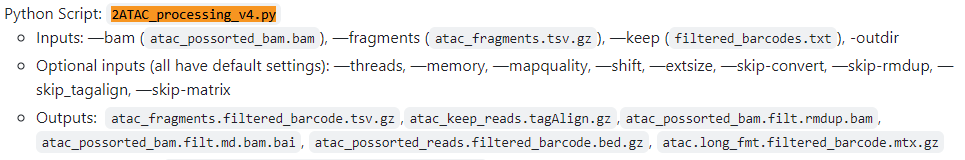

In [45]:
run_window_script <- function(samp, outdir, is.multiome=TRUE, script_path, cellranger_path) {
    bam <- paste0(cellranger_path,samp,'/outs/atac_possorted_bam.bam')
    if (!is.multiome) {
        bam <- paste0(cellranger_path,samp,'/outs/possorted_bam.bam')
    }
    
    fragments <- paste0(cellranger_path,samp,'/outs/atac_fragments.tsv.gz')
    if (!is.multiome) {
        fragments <- paste0(cellranger_path,samp,'/outs/fragments.tsv.gz')
    }
    
    system(paste0('mkdir ',outdir, samp,'/'))
    #setwd(paste0(outdir, samp,'/'))
    print(paste0('conda run -n windows_multiome_v4 python ', script_path, " --bam ", bam, " --fragments ", fragments, 
                  " --keep ", outdir, samp, '/', samp, "_filtered_barcodes.txt -o ", outdir, samp, "/ &> ", 
                  outdir, samp, "/",samp,"_log.txt "))
}

In [43]:
#Generate Plots and save in a nested set of lists. 
#Do this for each sample and cleanup each time to reduce memory.

dataset <- 'nPOD'
modality <- 'Multiome'

indir <- paste0("/nfs/lab/mega_pancreas/intermediates/Single_Sample_Processing_Intermediates/",dataset,'/231121_WE_SSP_Intermediates/Amulet_adatas/')
outdir <- paste0("/nfs/lab/mega_pancreas/intermediates/Single_Sample_Processing_Intermediates/",dataset,'/231121_WE_SSP_Intermediates/ATAC_Windows/')
script_path <- '/nfs/lab/mega_pancreas/notebooks/single_sample_processing/2ATAC_processing_v4.py'
cellranger_path <- paste0('/nfs/lab/projects/mega_pancreas/data/cellranger/', dataset,'/',modality,'/')
samp_dir <- paste0("/nfs/lab/projects/mega_pancreas/data/cellranger/",dataset,"/", modality, "/")

samples <- list.dirs(samp_dir, full.names = FALSE, recursive = FALSE)
samples

[1] "MM_510" "MM_660" "MM_661" "MM_662" "MM_663" "MM_664" "MM_665" "MM_666"
[9] "MM_667"

In [44]:
write.table(data.frame(unlist(parallel::mclapply(samples, run_window_script, outdir, is.multiome=(modality=='Multiome'), 
                   script_path, cellranger_path, mc.cores=16))),
            paste0(outdir, dataset, "_", modality, "_windows_commands_2.sh"),
            row.names=F, col.names=F, quote=F)